<a href="https://colab.research.google.com/github/aristotelis79/collab/blob/main/Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Categorizing intent


## Setup

Let's first import everything and load the dataset

In [1]:
!pip install textblob 'gensim==4.2.0'
!pip install keras.utils
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=e6bcc8f544314b9b426d25ea068321966f5dc338bb97c416357a447d99fa5b58
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 645.7 kB/s eta 0:00:00


In [2]:
import multiprocessing
import tensorflow as tf
import sys
import tensorflow.python.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, Input
from keras import utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.nn import leaky_relu
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk

epochs = 100
embedding_dim = 100
TRACE = False

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config)
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now we will download the dataset and explore it

In [3]:
%%writefile get_data.sh
if [ ! -f intents.csv ]; then
  wget -O intents.csv https://www.dropbox.com/s/smy3os4px8ionkx/atis_intents.csv?dl=0
fi

if [ ! -f glove.6B.100d.txt ]; then
  wget -O glove.6B.100d.txt https://www.dropbox.com/s/dl1vswq2sz5f1ws/glove.6B.100d.txt?dl=0
fi

Writing get_data.sh


In [4]:
!bash get_data.sh


--2024-04-28 07:47:40--  https://www.dropbox.com/s/smy3os4px8ionkx/atis_intents.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/smy3os4px8ionkx/atis_intents.csv [following]
--2024-04-28 07:47:40--  https://www.dropbox.com/s/raw/smy3os4px8ionkx/atis_intents.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1187b2d13f3a6a4d2890f8bd66.dl.dropboxusercontent.com/cd/0/inline/CR2i8DeDscvZZaFYDNtTZYd63TigTjjdWN15p_I6MOjPV2YQPkhENsE5csjh517MhuCPGUs3GdWZCeovP7lA5QK_2uR-nmgR_ed3MJmeoSv_XOgGVXO2BFGZuTtAVAGPE_WLj2kQELv-jZFmIdqOlzO2/file# [following]
--2024-04-28 07:47:41--  https://uc1187b2d13f3a6a4d2890f8bd66.dl.dropboxusercontent.com/cd/0/inline/CR2i8DeDscvZZaFYDNtTZYd63TigTjjdWN15p_I6MOjPV2YQPkhENsE5csjh517MhuCPGUs3GdWZCeovP7lA5

Let's inspect how this intents csv looks like

In [5]:
! head intents.csv

atis_flight, i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
atis_flight, what flights are available from pittsburgh to baltimore on thursday morning
atis_flight_time, what is the arrival time in san francisco for the 755 am flight leaving washington
atis_airfare, cheapest airfare from tacoma to orlando
atis_airfare, round trip fares from pittsburgh to philadelphia under 1000 dollars
atis_flight, i need a flight tomorrow from columbus to minneapolis
atis_aircraft, what kind of aircraft is used on a flight from cleveland to dallas
atis_flight, show me the flights from pittsburgh to los angeles on thursday
atis_flight, all flights from boston to washington
atis_ground_service, what kind of ground transportation is available in denver


In [6]:
def preprocess_text(text, should_join=True):
    text = ' '.join(str(word) for word in textblob_tokenizer(text))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [7]:
path = './intents.csv'
intents = pd.read_csv(path, header=None, names=["intent", "query"])
intents

,intent,query
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...
...,...,...
4973,atis_airfare,what is the airfare for flights from denver t...
4974,atis_flight,do you have any flights from denver to baltim...
4975,atis_airline,which airlines fly into and out of denver
4976,atis_flight,does continental fly from boston to san franc...


Let's inspect the intents

In [8]:
intents.intent.value_counts()

intent
atis_flight                                 3666
atis_airfare                                 423
atis_ground_service                          255
atis_airline                                 157
atis_abbreviation                            147
atis_aircraft                                 81
atis_flight_time                              54
atis_quantity                                 51
atis_flight#atis_airfare                      21
atis_airport                                  20
atis_distance                                 20
atis_city                                     19
atis_ground_fare                              18
atis_capacity                                 16
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               6
atis_airline#atis_flight_no                    2
atis_ground_service#atis_ground_fare           1
atis_airfare#atis_flight_time                  1
atis_cheapest

Let's filter the rows with a rare intent since we will not be able to predict it neverthenless

In [9]:
intents_filtered = intents.groupby('intent').filter(lambda x: len(x) >= 15).reset_index()

In [10]:
X = intents_filtered['query']
y = intents_filtered.intent


If we inspect y, now we need to transform it into a one hot representation!

In [11]:
y

0            atis_flight
1            atis_flight
2       atis_flight_time
3           atis_airfare
4           atis_airfare
              ...       
4943        atis_airfare
4944         atis_flight
4945        atis_airline
4946         atis_flight
4947         atis_flight
Name: intent, Length: 4948, dtype: object

## Creating the corpus and tokenizing

In [13]:
corpus_with_ix = [(ix, preprocess_text(sentence, should_join = True)) for ix, sentence in X.items() if type(sentence) == str and len(textblob_tokenizer(sentence)) > 3]


In [14]:
corpus_with_ix[0]

(0, 'want to fly from boston at am and arrive in denver at in the morning')

In [15]:
corpus_df = pd.DataFrame(corpus_with_ix, columns=['index', 'text'])

In [16]:
corpus_df

,index,text
0,0,want to fly from boston at am and arrive in de...
1,1,what flights are available from pittsburgh to ...
2,2,what is the arrival time in san francisco for ...
3,3,cheapest airfare from tacoma to orlando
4,4,round trip fares from pittsburgh to philadelph...
...,...,...
4866,4943,what is the airfare for flights from denver to...
4867,4944,do you have any flights from denver to baltimo...
4868,4945,which airlines fly into and out of denver
4869,4946,does continental fly from boston to san franci...


In [17]:
y_filtered = y[corpus_df['index']]

In [18]:
y_filtered

0            atis_flight
1            atis_flight
2       atis_flight_time
3           atis_airfare
4           atis_airfare
              ...       
4943        atis_airfare
4944         atis_flight
4945        atis_airline
4946         atis_flight
4947         atis_flight
Name: intent, Length: 4871, dtype: object

In [19]:
corpus = [preprocess_text(sentence, should_join=False) for ix, sentence in corpus_with_ix]

In [20]:
def get_maximum_review_length(tokenized_corpus):
    maximum = 0
    for sentence in tokenized_corpus:
        candidate = len(sentence)
        if candidate > maximum:
            maximum = candidate
    return maximum
max_review_length = get_maximum_review_length(corpus)

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
tokenized_corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
final_X = np.zeros((len(tokenized_corpus), max_review_length))
for ix, tokenized_sentence in enumerate(tokenized_corpus):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    final_X[ix] = tokenized_sentence

Since y_filtered (and y) have many text values, we need to map each intent into a number. We will use the `pd.factorize` method for that.

In [23]:
y_factorized, level_intents = pd.factorize(y_filtered)

In [24]:
y_factorized, level_intents

(array([0, 0, 1, ..., 6, 0, 0]),
 Index(['atis_flight', 'atis_flight_time', 'atis_airfare', 'atis_aircraft',
        'atis_ground_service', 'atis_airport', 'atis_airline', 'atis_distance',
        'atis_abbreviation', 'atis_ground_fare', 'atis_quantity', 'atis_city',
        'atis_capacity', 'atis_flight#atis_airfare'],
       dtype='object'))

## Creating the embedding matrix

This is the same part, we will construct an embedding matrix that maps each word in the tokenizer (via the ID it gets in the dataset) to the GloVe 100 dimensional representation of that word. This will be the input to the Embedding layer.

In [25]:
path_to_glove_file = "./glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


In [26]:
embedding_dim = 100
num_tokens = vocab_size + 1
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 696 words (1 misses)


## Doing the train_test split and defining model

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_X, y_factorized, test_size = 0.3, random_state=42)

In [28]:
X_train_tensor = tf.constant(X_train)
X_test_tensor = tf.constant(X_test)
y_train_tensor = tf.one_hot(tf.constant(y_train), len(level_intents))
y_test_tensor = tf.one_hot(tf.constant(y_test), len(level_intents))

Notice that our y has many values, we need to use `tf.one_hot` to convert it to the corresponding input to the loss function

In [29]:
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(TensorShape([3409, 43]),
 TensorShape([1462, 43]),
 TensorShape([3409, 14]),
 TensorShape([1462, 14]))

Now we have the key step, we will set the output neurons to be the amount of intents, with softmax as activation. Therefore this model will predict probabilities that each input inquiry is of certain classes

In [30]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], input_length=max_review_length, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dense(100, activation=leaky_relu))
model.add(Dense(50, activation=leaky_relu))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,)))
model.add(Dense(50, activation=leaky_relu))
model.add(Dense(len(level_intents), activation='softmax'))

In [31]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 100)           69900     
                                                                 
 dense (Dense)               (None, 43, 100)           10100     
                                                                 
 dense_1 (Dense)             (None, 43, 50)            5050      
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 14)                714       
                                                                 
Total params: 88314 (344.98 KB)
Trainable params: 18414 

Notice the non-trainable parameters

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=10, min_delta=0.01, mode="max")
history = model.fit(X_train_tensor, y_train_tensor, epochs = 30, validation_split=0.2, workers = 5, callbacks=[callback])

Epoch 1/30
86/86 [==============================] - 2s 12ms/step - loss: 1.3431 - accuracy: 0.7198 - precision: 0.7769 - recall: 0.5288 - val_loss: 0.9790 - val_accuracy: 0.7669 - val_precision: 0.7937 - val_recall: 0.7449
Epoch 2/30
86/86 [==============================] - 1s 8ms/step - loss: 0.9461 - accuracy: 0.7396 - precision: 0.8029 - recall: 0.7305 - val_loss: 0.8267 - val_accuracy: 0.7742 - val_precision: 0.8540 - val_recall: 0.7375
Epoch 3/30
86/86 [==============================] - 1s 9ms/step - loss: 0.7292 - accuracy: 0.8045 - precision: 0.8711 - recall: 0.7459 - val_loss: 0.6355 - val_accuracy: 0.8446 - val_precision: 0.8920 - val_recall: 0.7991
Epoch 4/30
86/86 [==============================] - 1s 9ms/step - loss: 0.5775 - accuracy: 0.8563 - precision: 0.9024 - recall: 0.8273 - val_loss: 0.5179 - val_accuracy: 0.8666 - val_precision: 0.9006 - val_recall: 0.8372
Epoch 5/30
86/86 [==============================] - 1s 9ms/step - loss: 0.4885 - accuracy: 0.8706 - precision: 

## Some plots

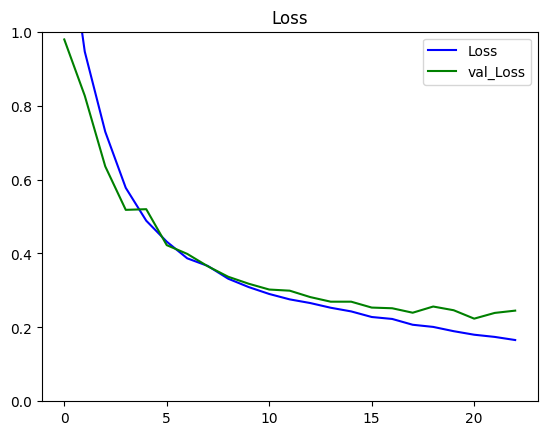

In [33]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)


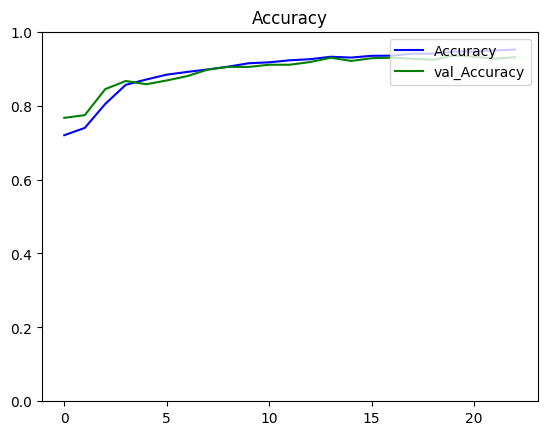

In [34]:
plot_metrics(history.history['accuracy'], history.history['val_accuracy'], "Accuracy", "Accuracy", ylim=1.0)


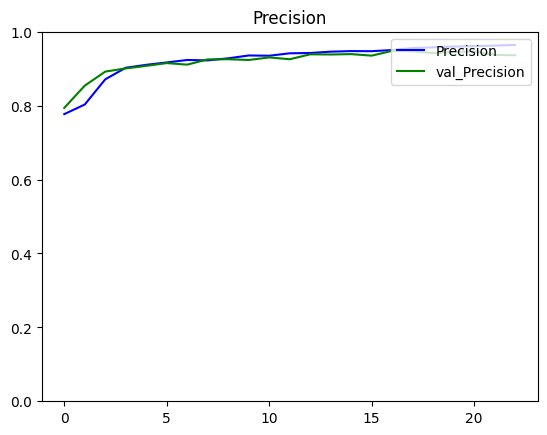

In [35]:
plot_metrics(history.history['precision'], history.history['val_precision'], "Precision", "Precision", ylim=1.0)


# Some manual validation

In [36]:
level_intents

Index(['atis_flight', 'atis_flight_time', 'atis_airfare', 'atis_aircraft',
       'atis_ground_service', 'atis_airport', 'atis_airline', 'atis_distance',
       'atis_abbreviation', 'atis_ground_fare', 'atis_quantity', 'atis_city',
       'atis_capacity', 'atis_flight#atis_airfare'],
      dtype='object')

In [37]:

x_val = np.zeros((4, max_review_length))
queries = ['Which hour is the next flight', 'how many flights leave in the morning', 'i want to flight to new york at the morning', 'which flight flies with an airbus A350']
for ix, tokenized_sentence in enumerate(tokenizer.texts_to_sequences([preprocess_text(sentence, should_join=True) for sentence in queries])):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    x_val[ix] = tokenized_sentence
y_val = tf.one_hot(tf.constant([1, 10, 0, 3 ]), 14)

In [38]:
x_val

array([[ 62.,  19.,   4., 111.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 78., 141.,   3.,  69.,  14.,   4.,  33.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 67.,   1.,   8.,   1.,  66.,  70.,  65.,   4.,  33.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 62.,   8., 278.,  56., 140.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0

In [39]:
model.predict(x_val)

1/1 [==============================] - 0s 172ms/step


array([[9.70639050e-01, 3.94142093e-03, 1.14679948e-04, 8.12933547e-04,
        5.55676743e-05, 4.34297230e-03, 1.51137076e-02, 4.43113706e-04,
        7.11084067e-05, 1.82999531e-06, 1.16626499e-03, 3.07266833e-03,
        1.05836894e-04, 1.18919277e-04],
       [8.47067356e-01, 2.58797817e-02, 3.50905512e-03, 7.78538967e-03,
        8.80580483e-05, 1.93350541e-03, 4.03762842e-03, 3.50402039e-03,
        1.84053148e-04, 4.58092545e-05, 9.46248919e-02, 5.28603839e-03,
        3.53216287e-03, 2.52217776e-03],
       [9.98898506e-01, 7.19997799e-04, 1.53221681e-05, 1.82141357e-05,
        3.59594651e-06, 1.56215479e-04, 1.09885739e-04, 1.90759856e-05,
        2.26600108e-07, 1.45855088e-08, 1.85788158e-05, 3.07975788e-05,
        2.91196272e-07, 9.34711261e-06],
       [7.73396075e-01, 1.56217779e-03, 3.42087083e-06, 3.53641738e-03,
        1.10109067e-05, 4.73090680e-03, 1.82158828e-01, 1.62397875e-04,
        1.32731284e-05, 2.98264837e-07, 3.16585600e-03, 3.07780094e-02,
        4.718

In [40]:
tf.math.argmax(model.predict(x_val), axis=1)

1/1 [==============================] - 0s 33ms/step


<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 0])>

In [41]:
tf.math.argmax(model.predict(x_val), axis=1) == tf.math.argmax(y_val, axis=1)

1/1 [==============================] - 0s 19ms/step


<tf.Tensor: shape=(4,), dtype=bool, numpy=array([False, False,  True, False])>

In [42]:
tf.math.argmax(y_val, axis=1)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 10,  0,  3])>

In [43]:
model.evaluate(X_test_tensor, y_test_tensor)

46/46 [==============================] - 0s 3ms/step - loss: 0.1945 - accuracy: 0.9425 - precision: 0.9581 - recall: 0.9378


[0.19449783861637115,
 0.9425444602966309,
 0.9580712914466858,
 0.9377564787864685]

Therefore, the model is amazing, reaching 95% accuracy and F1 score